# Загрузка библиотек

In [1]:
import jax
import torch
from torch.optim import Adam
import torch.nn as nn
from torch.autograd import Variable
import math
import numpy as np
import scipy.stats as sps
from numpy import linalg as LA
import jax.numpy as jnp

import pandas as pd

from collections import deque
from functools import partial
import time

# import sklearn.datasets as skldata


import seaborn as sns
import matplotlib.pyplot as plt

jax.config.update("jax_enable_x64", True)
plt.rcParams.update({"font.family": "Helvetica"})
sns.set_context("talk")
sns.set(font_scale=1.3, palette='Set2')

# Общие стандартные методы гладкой оптимизации

Самый обычный градиентный спуск, можно менять скорость от номера итерации, а также критерий остановки

In [2]:
def gradient_descent(f, nabla_f, x_0, lr,
                     K = 10**4, eps = 10**-6, criteria=0,
                              time_history=True):
    start_time = time.time()

    time_arr = []
    errors_arr = []
    x = x_0

    # start_grad = nabla_f(x_0)

    k = 1

    while True:
      # print(nabla_f(x))
      x_1 = x - lr(k) * nabla_f(x) # / start_grad


      error = criteria(x_1)

      errors_arr.append(error)

      x = x_1

      k += 1

      if time_history:
        time_arr.append(time.time() - start_time)

      if error < eps:
        break

      if k > K:
        break

    if time_history:
      return x, np.array(errors_arr), np.array(time_arr)
    return x, np.array(errors_arr)

Метод ускоренного градиентного спуска (Нестеров), можно менять скорость и момент от номера итерации, а также критерий остановки

In [3]:
def nesterov_gradient_descent(f, nabla_f, x_0, lr, tau,
                     K = 10**3, eps = 10**-6, criteria=0,
                              time_history=True):
    '''
        f - целевая функция
        nabla_f - градиент целевой функции
        x_0 - стартовая точка
        lr - функция для вычисления шага метода
        tau - функция для вычисления шага моментума метода
        K - количество итераций (по умолчанию 1е3)
        eps - желаемая точность (по умолчанию 1е-5)

        Функция возвращает точку, в которой достигается минимум и вектор ошибок
    '''
    start_time = time.time()

    time_arr = []
    errors_arr = []
    x = x_0
    y = x_0
    x_1 = x_0
    y_1 = x_0

    start_grad = nabla_f(x_0)

    k = 1

    while True:

      x_1 = y - lr(k) * nabla_f(x) # / start_grad
      y_1 = x_1 + tau(k) * (x_1 - x)


      error = criteria(x_1)

      errors_arr.append(error)

      x = x_1
      y = y_1

      k += 1

      if time_history:
        time_arr.append(time.time() - start_time)

      if error < eps:
        break

      if k > K:
        break

    if time_history:
      return x, np.array(errors_arr), np.array(time_arr)
    return x, np.array(errors_arr)

Метод ADAM, можно менять скорость от номера итерации, а также критерий остановки

# Общие функции для приближения градиента

Варианты приближения градиента:

Central finite difference (Central)
 $$\nabla f_{\gamma} (x, e) = d \frac{f (x + \gamma e) - f (x - \gamma e)}{2 \gamma} e \qquad (2)$$

Forward finite difference (Forward)
$$\nabla f_{\gamma} (x, e) = d \frac{f (x + \gamma e) - f (x)}{\gamma} e. \qquad (14)$$


In [17]:
def sample_spherical(npoints, d=3):
  '''
        npoints -  кол-во точек, которое хотим получить
        d - размерность сферы

        Функция возвращает npoints случайных точек на сфере S^d_2 единичного радиуса с центром в нуле
  '''
  vec = np.random.randn(d, npoints)
  vec /= np.linalg.norm(vec, axis=0)
  return vec

In [5]:
def central_gradient_approximation_direction(oracul, gamma, x, e):
  '''
        oracul - оракул, который возвращает значения в 2 точках для одного значения случайной величины
        gamma - окрестность
        x - точка
        e - вектор, по которому ищем градиент

        Функция возвращает градиент
    '''
  assert(gamma != 0)
  assert(x.shape == e.shape)
  points = np.concatenate((x - gamma * e, x + gamma * e),axis=1)
  values = oracul.get_two_values(points)
  return x.shape[0] * (values[1] - values[0]) / (2 * gamma) * e

In [51]:
def forward_gradient_approximation_direction(oracul, gamma, x, e):
  '''
        oracul - оракул, который возвращает значения в 2 точках для одного значения случайной величины
        gamma - окрестность
        x - точка
        e - вектор, по которому ищем градиент

        Функция возвращает градиент
    '''
  assert(gamma != 0)
  assert(x.shape == e.shape)
  points = np.concatenate((x, x + gamma * e),axis=1)
  values = oracul.get_two_values(points)
  return x.shape[0] * (values[1] - values[0]) / (2 * gamma) * e

Координатный Central подход: отдельно считаем для каждого $e = (0, \ldots 1, \ldots  0)^T$, где на $i$-той позиции $1$.

Central подход: считаем для $e \sim RS_d^2(1)$ случайный вектор с равномерным распределением на сфере.

In [50]:
def gradient_approximation_central(oracul, gamma, x, coordinates=False):
    '''
        oracul - оракул, который возвращает значения в 2 точках для одного значения случайной величины
        gamma - окрестность
        x - точка
        coordinates - True\False, считать отдельно по каждому направлению или нет
        Функция возвращает приближение градиента
    '''
    assert(gamma != 0)

    d = x.shape[0]

    if not coordinates:
      e = sample_spherical(1, d)
      return central_gradient_approximation_direction(oracul, gamma, x,
                                                    e)


    grads = 0
    for i in range(d):
      e = np.zeros(x.shape)
      e[i, 0] = 1
      grads += central_gradient_approximation_direction(oracul, gamma, x, e)
    return grads

Координатный Forward подход: отдельно считаем для каждого $e = (0, \ldots 1, \ldots  0)^T$, где на $i$-той позиции $1$.

Forward подход: считаем для $e = (1, \ldots 1)^T$

In [49]:
def gradient_approximation_forward(oracul, gamma, x, coordinates=False):
    '''
        oracul - оракул, который возвращает значение в 1 точке
        gamma - окрестность
        x - точка
        coordinates - True\False, считать отдельно по каждому направлению или нет
        Функция возвращает приближение градиента
    '''
    assert(gamma != 0)

    d = x.shape[0]


    if not coordinates:
      e = sample_spherical(1, d)
      return forward_gradient_approximation_direction(oracul, gamma, x,
                                                    e)

    value_in_x = oracul.get_one_value(x)

    grads = 0
    for i in range(d):
      e = np.zeros((x.shape))
      e[i, 0] = 1
      value = oracul.get_one_value(x + gamma * e)
      grad = d * (value - value_in_x) * e / gamma
      grads += grad
    return grads

# Функции для графиков

In [59]:
def plot_loss_by_step(errors_lists, names_list, title=None):
  assert(len(errors_lists) == len(names_list))
  plt.figure(figsize=(12, 6))

  for i in range(len(names_list)):
    plt.plot(np.arange(len(errors_lists[i])), errors_lists[i], label=names_list[i])

  plt.legend()

  plt.yscale('log')

  plt.xlabel('Номер итерации')
  plt.ylabel('Значения функции потерь')

  if title == None:
    plt.title('Сходимость для разных методов аппроксимации градиента', fontsize=20)
  else:
    plt.title(title, fontsize=20)
  plt.show()

In [62]:
def plot_loss_by_time(time_lists, errors_lists, names_list, title=None):
  assert(len(errors_lists) == len(names_list))
  assert(len(errors_lists) == len(time_lists))
  plt.figure(figsize=(12, 6))

  for i in range(len(names_list)):
    plt.plot(time_lists[i], errors_lists[i], label=names_list[i])

  plt.legend()

  plt.yscale('log')

  plt.xlabel('Время, с')
  plt.ylabel('Значения функции потерь')

  if title == None:
    plt.title('Сходимость для разных методов аппроксимации градиента', fontsize=20)
  else:
    plt.title(title, fontsize=20)
  plt.show()

# LAD Regression

## Загрузка данных

In [9]:
def replace_categories(df):
  encoder = {'I': 0, 'F': 1, 'M': 2}
  df.iloc[:, 0] = df.iloc[:, 0].apply(lambda x: encoder[x])
  return df

In [10]:
dataset = 'abalone_train.csv'

In [11]:
data = pd.read_csv(dataset, header=None)

data = replace_categories(data)
X, y = data.iloc[:, 0:-1].to_numpy(), data.iloc[:, -1].to_numpy()

<ipython-input-9-239415b96ca5>:3: DeprecationWarning: In a future version, `df.iloc[:, i] = newvals` will attempt to set the values inplace instead of always setting a new array. To retain the old behavior, use either `df[df.columns[i]] = newvals` or, if columns are non-unique, `df.isetitem(i, newvals)`
  df.iloc[:, 0] = df.iloc[:, 0].apply(lambda x: encoder[x])


we divide dataset "abalone scale" into two parts, where the part for training is 3500 samples. The dimension of features equals to 8. So, it is a very small dataset. We take dataset with such small dimension to compare Forward and Central with their variants of coordinate steps that depend on dimension.

In [12]:
from sklearn.model_selection import train_test_split
X_train, X_val, y_train, y_val = train_test_split(X, y, test_size=0.2, random_state=42)

## Функция потерь и оракул 0-порядка

Least absolute deviation (LAD) regression
$$\min_{w \in R^d} \{f (w) = \frac{1}{m} \sum^m_{k=1}|x^T_k w - y_k|\} \qquad \mbox{негладкая функция}$$
задача оптимизации с конечной суммой


Оракул нулевого порядка, который выдает значения в 1 или 2 точках (для одного $i$) за один запрос.

In [13]:
class LADZeroOrderOracul:
  def __init__(self, X, y):
    assert(X.shape[0] == y.shape[0])
    self.X = X
    self.y = y

  def get_one_value(self, w):
    assert(w.shape == (self.X.shape[1], 1))
    i = np.random.randint(self.X.shape[0], size=1)
    return np.abs(self.X[i] @ w - self.y[i])[0, 0]

  def get_two_values(self, w):
    assert(w.shape == (self.X.shape[1], 2))
    i = np.random.randint(self.X.shape[0], size=1)
    return np.abs(self.X[i] @ w - self.y[i])[0]

  def get_total_loss(self, w):
    assert(w.shape == (self.X.shape[1], 1))
    return np.mean(np.abs(self.X @ w - self.y))

  def get_total_grad(self, w):
    assert(w.shape == (self.X.shape[1], 1))
    preds = self.X @ w
    signs  = 2 * (preds > self.y) - 1
    return np.mean(self.X * signs, axis=0).reshape((-1,1))

Функция потерь и градиент всей функции потерь для экспериментов

## Нахождение $\gamma$

$M_2$  -- константа Липшица для функции $f$ и нормы $2$:

$|f (w_2) - f (w_1)| \leq M_2 ||w_2 - w_1||_2$ на $Q_\gamma$

$\frac{1}{m} \sum^m_{k=1}(|x^T_k w_2 - y_i| - |x^T_k w_1 - y_i|) \leq \frac{1}{m} \sum^m_{k=1} |x^T_k (w_2 - w_1)| \leq $

$M_2 = \max \{ |x_i^j| \; | \; 1 \leq i \leq m, \; 1 \leq j \leq d \}$

$\varepsilon $ -- точность, с которой хотим решить

Тогда берем $\gamma = \varepsilon/(2 M_2)$

In [32]:
eps = 1e-3
M2 = np.max(np.abs(X_train))
lad_gamma = eps / (2 * M2)
print(lad_gamma)

0.0001769598301185631


## Эксперимент

In [33]:
lad_oracul = LADZeroOrderOracul(X_train, y_train.reshape((-1, 1)))
f = lambda w: lad_oracul.get_total_loss(w)
criteria = lambda w: lad_oracul.get_total_loss(w)

### Несколько тестов работы Оракула

In [218]:
w  = np.ones((8, 2))
w[:, 1] = 1.05

In [219]:
lad_oracul.get_two_values(w)

array([1.487  , 1.71135])

In [220]:
w  = np.ones((8, 1))
lad_oracul.get_total_grad(w)

array([[1.01356203],
       [0.43866374],
       [0.34299761],
       [0.1171799 ],
       [0.7537874 ],
       [0.32893319],
       [0.16462704],
       [0.21553889]])

In [221]:
criteria(w)

1.7957126047068208

In [222]:
lad_oracul.get_total_loss(np.ones((8, 1)))

1.7957126047068208

In [18]:
w_0 = np.random.uniform(0, 1,(8, 1))
gradient_approximation_central(lad_oracul, lad_gamma, w_0)

array([[ 2.42734576],
       [ 0.33008411],
       [ 0.7058576 ],
       [ 4.9638564 ],
       [ 3.27118403],
       [-0.72989717],
       [ 0.68347454],
       [-2.95734786]])

### Приближение градиента Central

In [64]:
nablas = {'central': lambda w: gradient_approximation_central(lad_oracul, lad_gamma, w),
          'forward': lambda w: gradient_approximation_forward(lad_oracul, lad_gamma, w),
          'gradient': lambda w: lad_oracul.get_total_grad(w)}
errors = {'central': [], 'forward': [], 'gradient': []}
times = {'central': [], 'forward': [], 'gradient': []}
lrs = {'central': 0.01, 'forward': 0.01, 'gradient': 0.01}

In [65]:
w_0 = np.zeros((X_train.shape[1], 1))
# np.random.uniform(0, 1,(X_train.shape[1], 1))

for method_name in errors.keys():
  nabla_f = nablas[method_name]
  w_opt, errors[method_name], times[method_name] = gradient_descent(f, nabla_f, w_0,
                                    lr = lambda k: 0.001,
                                    K = 10**4, eps=eps,
                                    criteria=criteria, time_history=True)

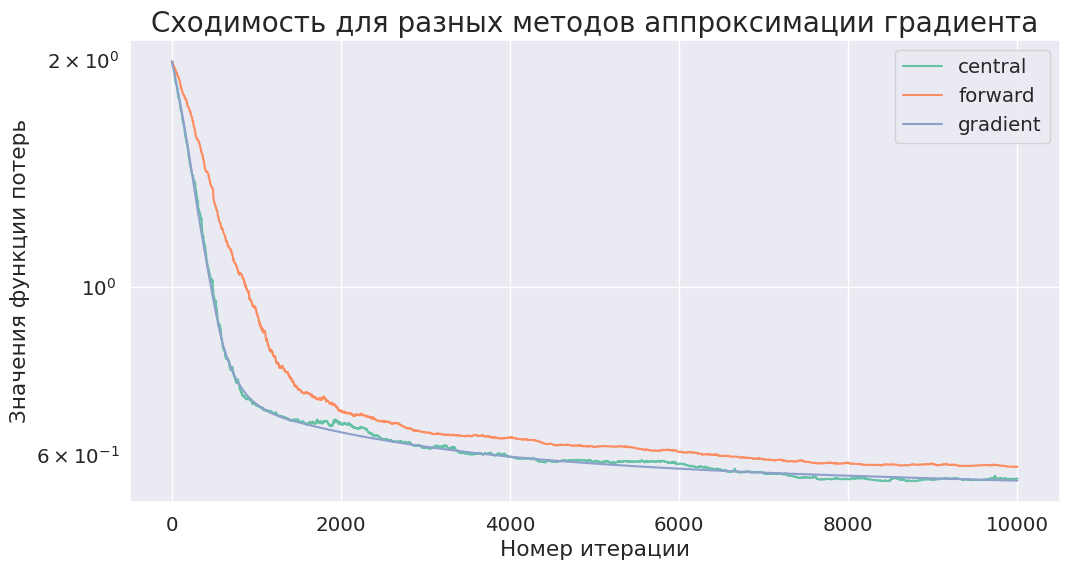

In [66]:
plot_loss_by_step(list(errors.values()), list(errors.keys()))

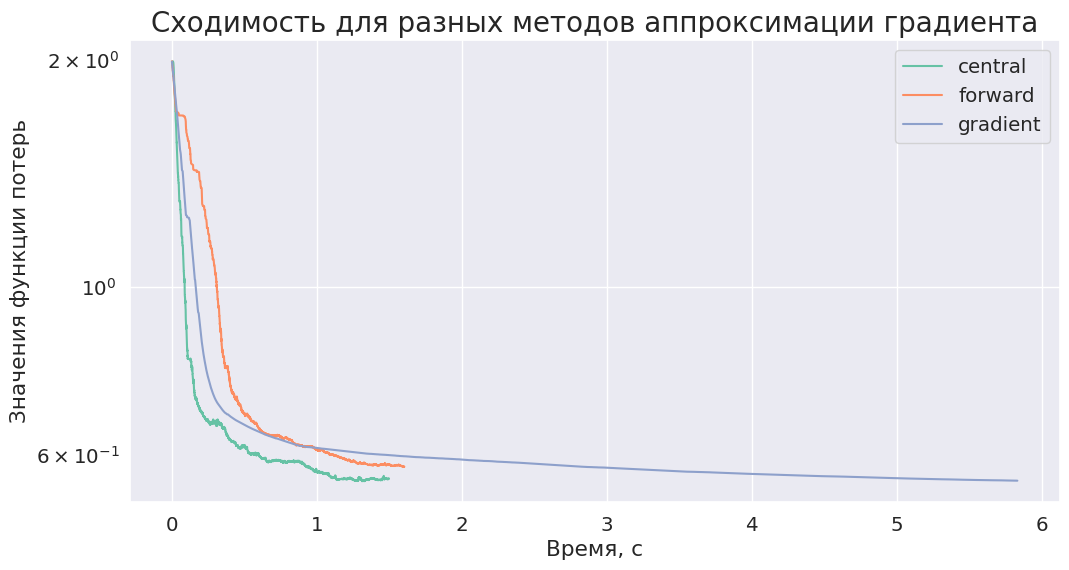

In [67]:
plot_loss_by_time(list(times.values()), list(errors.values()), list(errors.keys()))

Вывод: оба метода аппроксимации градиента гораздо быстрее градиентного спуска, при этом находят почти такие же результаты.

# SVM